In [2]:
!pip install chess

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import copy
import pickle

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
with open("drive/MyDrive/datasets/chess_dataset/input.pickle", "rb") as file:
  input_data = pickle.load(file)

with open("drive/MyDrive/datasets/chess_dataset/output.pickle", "rb") as file:
  output_data = pickle.load(file)

In [6]:
# input_data = input_data / input_data.max()
# output_data = output_data / output_data.max()

In [7]:
input_data, output_data, input_data.shape, output_data.shape

(array([[12,  9,  7, ...,  1,  3,  6],
        [12,  9,  7, ...,  1,  3,  6],
        [12,  9,  7, ...,  1,  0,  6],
        ...,
        [ 0, 12,  0, ...,  0,  2,  0],
        [ 0, 12,  0, ...,  0,  2,  0],
        [ 0,  3,  0, ...,  0,  2,  0]]), array([[6, 4, 4, 4],
        [7, 6, 5, 5],
        [7, 5, 3, 1],
        ...,
        [3, 4, 2, 2],
        [2, 2, 0, 1],
        [3, 6, 6, 3]], dtype=int8), (970731, 64), (970731, 4))

In [8]:
def base_2(x):
  return {
    0 : [0, 0, 0],
    1 : [0, 0, 1],
    2 : [0, 1, 0],
    3 : [0, 1, 1],
    4 : [1, 0, 0],
    5 : [1, 0, 1],
    6 : [1, 1, 0],
    7 : [1, 1, 1],
  }[x]

def decimal(x):
  bits = [1 if 1 - x_ < 0.5 else 0 for x_ in x]
  for i in range(8):
    if base_2(i) == bits:
      return i

In [9]:
base_2(1), decimal([0.1, 0.1, 0.7])

([0, 0, 1], 1)

In [10]:
X = input_data / input_data.max()
# y = output_data / output_data.max()
X = X[:400000]
#.reshape(400000, 8, 8, 1)
# y = y[:400000]

In [14]:
y = []
for o in output_data:
  y.append([base_2(int(i)) for i in o])

In [17]:
y = np.array(y[:400000]).reshape(len(y[:400000]), 12)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2021, shuffle=True)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((360000, 64), (40000, 64), (360000, 12), (40000, 12))

In [176]:
unit_size = 2048

In [177]:
model = keras.Sequential()
model.add(layers.Dense(unit_size, input_shape=X_train.shape[1:], activation="relu"))
# model.add(layers.Dropout(0.4))
model.add(layers.Dense(unit_size, activation="relu", kernel_regularizer=keras.regularizers.L1(1e-7)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(unit_size, activation="relu", kernel_regularizer=keras.regularizers.L1(1e-7)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(unit_size, activation="relu", kernel_regularizer=keras.regularizers.L1(1e-7)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(unit_size/2, activation="relu", kernel_regularizer=keras.regularizers.L1(1e-7)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(unit_size/4, activation="relu", kernel_regularizer=keras.regularizers.L1(1e-7)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(12, activation="sigmoid"))
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_90 (Dense)             (None, 2048)              133120    
_________________________________________________________________
dense_91 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_50 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_51 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_93 (Dense)             (None, 2048)              4196352   
_________________________________________________________________
dropout_52 (Dropout)         (None, 2048)            

In [102]:
# with open("drive/MyDrive/datasets/chess_dataset/trained_weights/weights_MSE_0.1406.pickle", "rb") as file:
#   weights = pickle.load(file)
#   model.set_weights(weights)
model.set_weights(current_weights)

In [110]:
# model = keras.models.Sequential()
# model.add(layers.Conv2D(1024, (3, 3), input_shape=(8, 8, 1), activation="relu"))
# model.add(layers.MaxPool2D(2, 2))
# model.add(layers.Conv2D(1024, (2, 2), activation="relu"))
# model.add(layers.MaxPool2D(2, 2))
# model.add(layers.Conv2D(1024, (1, 1), activation="relu"))
# model.add(layers.MaxPool2D(1, 1))
# model.add(layers.Flatten())
# model.add(layers.Dense(12, activation="sigmoid"))
# model.summary()

In [178]:
sgd = keras.optimizers.SGD(learning_rate=0.1, momentum=0.0)

def loss(y, y_pred):
  return tf.reduce_sum(tf.sqrt(y - y_pred))

model.compile(loss=keras.losses.MeanSquaredError(),
              optimizer="adam")

In [180]:
model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=256)

Epoch 1/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.1988 - val_loss: 0.2042
Epoch 2/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.1975 - val_loss: 0.2045
Epoch 3/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.1963 - val_loss: 0.2044
Epoch 4/10
1407/1407 [==============================] - 36s 26ms/step - loss: 0.1952 - val_loss: 0.2048
Epoch 5/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.1942 - val_loss: 0.2052
Epoch 6/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.1931 - val_loss: 0.2046
Epoch 7/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.1922 - val_loss: 0.2052
Epoch 8/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.1912 - val_loss: 0.2058
Epoch 9/10
1407/1407 [==============================] - 36s 25ms/step - loss: 0.1903 - val_loss: 0.2058
Epoch 10/10
1407/1407 [==============================] - 36s 25m

In [93]:
current_weights = copy.deepcopy(model.get_weights())

In [208]:
with open("drive/MyDrive/datasets/chess_dataset/trained_weights/weights_f6_0.2058.pickle", "wb") as file:
  pickle.dump(model.get_weights(), file)

In [115]:
import chess

In [116]:
unique_cells = sorted(set("""
r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . N . .
P P P P . P P P
R N B Q K B . R"""))

unique_cells.remove("\n")
unique_cells.remove(" ")

unique_figures = np.array(list(set([x.upper() for x in unique_cells[1:]])))


fig_dict = {n : i for i, n in enumerate(unique_cells)}
num_dict = {i : n for i, n in enumerate(unique_cells)}


def fig_to_num(f): return fig_dict[f]
def num_to_fig(n): return num_dict[n]


def board_to_input(board):
    inp = []
    board = str(board).replace("\n", '').replace(" ", '')
    board.replace(" ", '')
    for s in board:
        inp.append(fig_to_num(s))
    return inp

num_pos_dict = {n : p for n, p in enumerate("abcdefgh")}

def num_pos_to_board_pos(pos):
    return f"{num_pos_dict[pos[1]]}{8 - pos[0]}"

In [199]:
def next_move(board):
    # board.push_uci(move)
    # print("your move approved.")
    
    inp = np.array(board_to_input(board))
    inp = inp / inp.max()
    net_move = model.predict(np.array([inp]))[0]
    # net_move = (net_move*8).round().astype(np.int8)
    # net_move = net_move - 1
    x1 = decimal(net_move[:3])
    y1 = decimal(net_move[3:6])
    x2 = decimal(net_move[6:9])
    y2 = decimal(net_move[9:12])
    print(x1, y1, x2, y2)
    net_move = f"{num_pos_to_board_pos([x1, y1])}{num_pos_to_board_pos([x2, y2])}"
    board.push_uci(net_move)
    display(board)

6 4 4 4


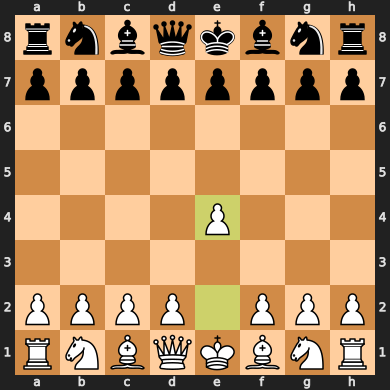

In [201]:
board = chess.Board()
next_move(board)

In [207]:
# board.push_uci("e5d4")
board.push_san("d6")
next_move(board)

7 3 5 1


ValueError: ignored